<a href="https://colab.research.google.com/github/RossPereira/DetectarPecasDefeituosas/blob/main/DetectarPecasDefeituosas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROBLEMA DE NEGÓCIO:**

Lidar com uma linha de produção é algo desafiador, principalmente a questão de lidar com peças defeituosas, por mas que as linhas de montagem sejam automatizadas, na maioria do casos a verificação da qualidade das peças ainda é feita de forma manual

Pensando em como melhorar essa gargalo será construida uma solução que utliza 2 redes neurais a primeira para identificar se há um problema na peça submetida ao modelo e uma segunda rede para identificar a localização do defeito

## **CARREGANDO DADOS, BIBLIOTECAS E ANÁLISES DESCRITIVAS:**

In [ ]:
# Caso tenha algum problema com a importação do keras instale a versão abaixo do tensorflow
!pip install tensorflow==2.7

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Dense, Input, AveragePooling2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, UpSampling2D, Concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Carregando a Base que possui todas as imagens tanto as que Possuem Defeito como as que Não Possuem
all_images_df = pd.read_csv('/content/drive/MyDrive/Portfolio/Bases/ManutencaoPecas/defect_and_no_defect.csv')

In [5]:
all_images_df.shape

(12997, 2)

In [6]:
# Label 1 - Imagens De Peças com Defeito
# Label 0 - Imagens De Peças sem Defeito
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


In [7]:
# Essa base contem as imagens de peças com defeito e também a máscara de onde o defeito está na peça.
defect_class_mask_df = pd.read_csv('/content/drive/MyDrive/Portfolio/Bases/ManutencaoPecas/train.csv')

In [8]:
defect_class_mask_df.shape

(5748, 3)

In [9]:
# Pegando uma porcentagem rápida de quantas imagens possuem peças com defeito no primeiro dataframe
(defect_class_mask_df.shape[0] / all_images_df.shape[0]) * 100

44.22559052088943

In [10]:
defect_class_mask_df

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...
...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...


In [11]:
# A Coluna ClassId representa os tipos de defeito que temos na base
# Vamos verificar quantos tipos de defeitos temos
defect_class_mask_df['ClassId'].unique()

array([1, 3, 4, 2])

## **ANÁLISES EXPLORATÓRIAS:**

In [12]:
all_images_df['label'].value_counts()

1    7095
0    5902
Name: label, dtype: int64

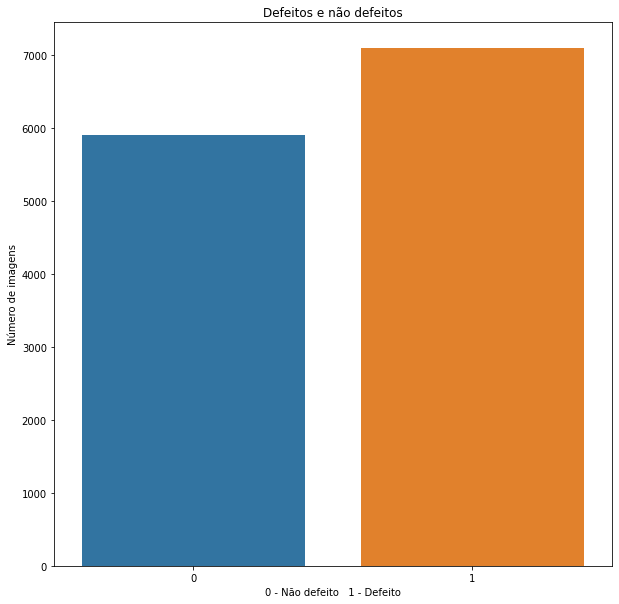

In [13]:
plt.figure(figsize=(10,10))
sns.barplot(x = all_images_df['label'].value_counts().index, y = all_images_df['label'].value_counts())
plt.ylabel('Número de imagens')
plt.xlabel('0 - Não defeito   1 - Defeito')
plt.title('Defeitos e não defeitos');

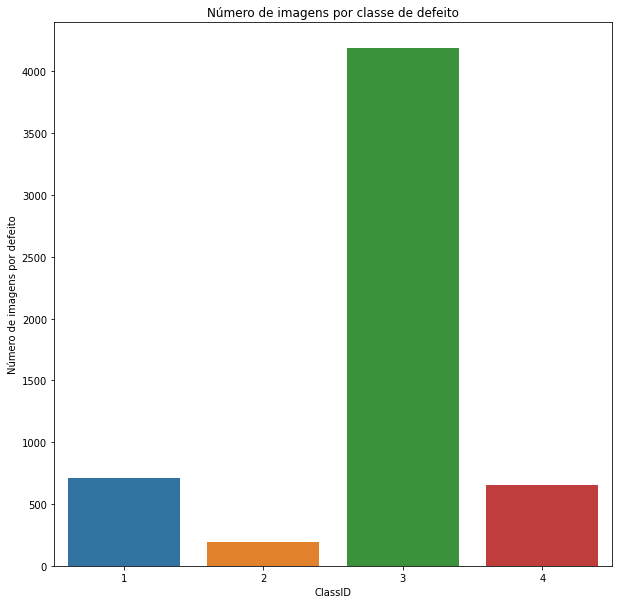

In [14]:
plt.figure(figsize=(10,10))
sns.countplot(x = defect_class_mask_df['ClassId'])
plt.ylabel('Número de imagens por defeito')
plt.xlabel('ClassID')
plt.title('Número de imagens por classe de defeito');

In [15]:
# Verificando o numero de defeitos por imagem, pois algumas imagens possuimos mais de um tipo de defeito
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)

In [16]:
defect_class_mask_df.head()

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1


In [17]:
defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum()
defect_type

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 5474, dtype: int64

In [18]:
defect_type.value_counts()

1    5201
2     272
3       1
Name: mask, dtype: int64

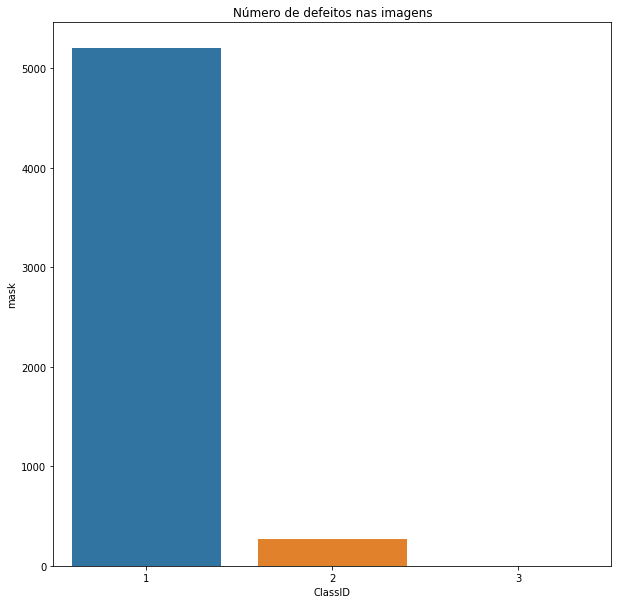

In [19]:
plt.figure(figsize=(10,10))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts())
plt.xlabel('ClassID')
plt.title('Número de defeitos nas imagens');

# **SOLUÇÃO PROPOSTA**

Será construida uma solução que utliza 2 redes neurais a primeira para identificar se há um problema na peça submetida ao modelo e uma segunda rede para identificar a localização do defeito.

##**Rede neural para prever se existe defeito em uma imagem:**

In [20]:
# Essa divisão entre treino e teste é um pouco diferente pois nao temos uma variavel alvo e sim uma base que indica o caminho da pasta onde estao as imagens
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_images_df, test_size = 0.15)

In [21]:
train.shape

(11047, 2)

In [22]:
test.shape

(1950, 2)

In [23]:
train_dir = '/content/drive/MyDrive/Portfolio/Bases/ManutencaoPecas/train_images'

In [24]:
# Fazendo a leitura das imagens em disco
from keras_preprocessing.image import ImageDataGenerator

In [25]:
# Redimensionando as imagens para uma escala entre 1 e 0 e separando mais 15% da base de treinamento para validação
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

In [26]:
# Gerando a base com as imagens de treino
train_generator = datagen.flow_from_dataframe(dataframe=train, directory=train_dir,
                                              x_col = 'ImageID', y_col = 'label',
                                              subset = 'training', batch_size = 16,
                                              shuffle = True, class_mode = 'other',
                                              target_size = (256,256))

Found 9390 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="ImageID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [27]:
# Gerando a base com as imagens de teste
valid_generator = datagen.flow_from_dataframe(dataframe=train, directory=train_dir,
                                              x_col = 'ImageID', y_col = 'label',
                                              subset = 'validation', batch_size = 16,
                                              shuffle = True, class_mode = 'other',
                                              target_size = (256,256))

Found 1656 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="ImageID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [28]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(dataframe = test, directory=train_dir,
                                                  x_col = 'ImageID', y_col = None,
                                                  batch_size = 16, shuffle = False,
                                                  class_mode = None, target_size = (256, 256))

Found 1950 validated image filenames.


**Carregando a Rede Neural Resnet e fazendo a transferência de aprendizagem**

In [29]:
# a Resnet é uma arquitetura de rede neural que foi treinada com uma base de 11 milhoes de imagens chamada imagenet, nesse caso sera usada a transferencia de aprendizagem para o nosso problema
# Carregando a rede com os pesos pré treinados
basemodel = ResNet50(weights='imagenet', include_top=False, input_tensor= Input(shape=(256, 256, 3)))

94781440/94765736 [==============================] - 0s 0us/step


In [30]:
# Visualizando as camadas da rede neural
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [31]:
# Verificando a Quantidade de Camadas e 'Congelando' os pesos para evitar o retreino
len(basemodel.layers)

175

In [32]:
for layer in basemodel.layers:
  layers.trainable = False

In [33]:
# Contruindo a camada densa personalizada
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten()(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)# zera 30% da camada densa para evitar o overfiting
headmodel = Dense(1, activation='sigmoid')(headmodel)

In [34]:
model = Model(inputs = basemodel.input, outputs = headmodel)

In [35]:
# Foram feitos testes com outros otimizadores mas o Nadam apresentou resultados melhores
model.compile(loss = 'binary_crossentropy', optimizer = 'Nadam', metrics = ['accuracy'])

In [36]:
# Essa função essencialmente verifica a diminuição do erro, se depois de 20 epocas o valor nao diminuir nos paramos o treinamento antecipadamente
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=20)

In [37]:
checkpointer = ModelCheckpoint(filepath='weights.hdf5', save_best_only=True)

In [ ]:
history = Model.fit(train_generator, epochs = 40, 
                              validation_data= valid_generator, 
                              callbacks=[checkpointer, earlystopping])

In [ ]:
# Salvando a extrutura da rede neural
model_json = model.to_json()
with open("resnet-classifier-model.json","w") as json_file:
  json_file.write(model_json)

**Avaliação da ResNet de Classificação:**

In [39]:
# Abrindo o modelo ja treinado
with open('/content/drive/MyDrive/Portfolio/Bases/ManutencaoPecas/resnet-classifier-model.json', 'r') as json_file:
  json_saved_model = json_file.read()

In [40]:
# Criando uma rede neural com a mesma estrutura da salva e carregando os pesos
model = tf.keras.models.model_from_json(json_saved_model)
model.load_weights('/content/drive/MyDrive/Portfolio/Bases/ManutencaoPecas/weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])

In [41]:
test_predict = model.predict(test_generator, verbose=True)

122/122 [==============================] - 579s 5s/step


In [42]:
# Separando as imagens com defeitos das sem defeitos
predict = []
for i in test_predict:
  if i < 0.01: # definindo 0.01 o algoritmo precisa ter 99% de certeza para classificarmos uma imagem com defeito
    predict.append(0)
  else:
    predict.append(1)
predict = np.asarray(predict)

In [43]:
len(predict)

1950

In [44]:
# Comparando as previsoes com a base de teste
original = np.asarray(test.label)

In [45]:
from sklearn.metrics import accuracy_score
accuracy_score(original, predict)

0.8897435897435897

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, predict)

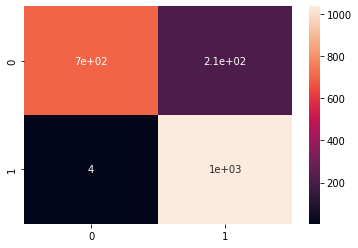

In [47]:
sns.heatmap(cm, annot=True);

In [48]:
from sklearn.metrics import classification_report
print(classification_report(original, predict))

              precision    recall  f1-score   support

           0       0.99      0.77      0.87       910
           1       0.83      1.00      0.91      1040

    accuracy                           0.89      1950
   macro avg       0.91      0.88      0.89      1950
weighted avg       0.91      0.89      0.89      1950



##**Rede neural para segmentação de imagens com ResUnet:**

In [49]:
# Divisão da base com imagens de defeito entre treinamento e teste
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(defect_class_mask_df, test_size = 0.2)

In [50]:
X_train.shape, X_val.shape

((4598, 4), (1150, 4))

In [52]:
# Transformando os dados em formato de lista
train_ids = list(X_train['ImageId'])
train_class = list(X_train['ClassId'])
train_rle = list(X_train['EncodedPixels'])

In [53]:
val_ids = list(X_val['ImageId'])
val_class = list(X_val['ClassId'])
val_rle = list(X_val['EncodedPixels'])

In [63]:
os.chdir('/content/drive/MyDrive/Portfolio/Bases/ManutencaoPecas')

In [65]:
# Utilities foi um arquivo criado com funções para processar imagens
from utilities import DataGenerator

In [66]:
training_generator = DataGenerator(train_ids, train_class, train_rle, train_dir)
validation_generator = DataGenerator(val_ids, val_class, val_rle, train_dir)

In [55]:
def resblock(X, f):
  X_copy = X

  # he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528
  X = Conv2D(f, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  # padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow
  # padding: https://wandb.ai/krishamehta/seo/reports/Difference-Between-SAME-and-VALID-Padding-in-TensorFlow--VmlldzoxODkwMzE
  X = Conv2D(f, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
  X = BatchNormalization()(X)

  X_copy = Conv2D(f, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  X = Add()([X, X_copy])
  X = Activation('relu')(X)

  return X

In [56]:
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])
  return merge

In [58]:
# Construção da arquitetura completa
input_shape = (256, 256, 1)
X_input = Input(input_shape)

# Estágio 1
conv1_in = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size=(2,2))(conv1_in)

# Estágio 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size=(2,2))(conv2_in)

# Estágio 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size=(2,2))(conv3_in)

# Estágio 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size=(2,2))(conv4_in)

# Estágio 5
conv5_in = resblock(pool_4, 256)

# Up 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Up 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Up 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Up 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final
output = Conv2D(4, (1,1), padding='same', activation='sigmoid')(up_4)
model_seg = Model(inputs = X_input, outputs = output)

**Loss function**

- Precisamos de uma função de erro personalizada para treinar a ResUnet
- Mais informações: https://arxiv.org/abs/1810.07842
- Fonte: https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py

In [67]:
from utilities import focal_tversky, tversky_loss, tversky

In [68]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon=0.1)
model_seg.compile(optimizer=adam, loss=focal_tversky, metrics=[tversky])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [70]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20) # Se depois de 20 epocas a função de perda nao reduzir forçamos a parada do treinamento
checkpointer = ModelCheckpoint(filepath='resunet-segmentation-weights.hdf5', verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit_generator(training_generator, epochs = 40,
                                  validation_data = validation_generator,
                                  callbacks = [checkpointer, earlystopping])

In [ ]:
# Salvando a arquitetura da rede neural
model_json = model_seg.to_json()
with open("resunet-segmentation-model.json","w") as json_file:
  json_file.write(model_json)

**Avaliação da ResUnet:**

In [71]:
# Carregando a arquitetura da rede neural salva
with open('/content/drive/MyDrive/Portfolio/Bases/ManutencaoPecas/resunet-segmentation-model.json') as json_file:
  json_saved_model = json_file.read()

In [72]:
model_seg = tf.keras.models.model_from_json(json_saved_model)
model_seg.load_weights('/content/drive/MyDrive/Portfolio/Bases/ManutencaoPecas/weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon=0.1)
model_seg.compile(optimizer=adam, loss=focal_tversky, metrics=[tversky])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [73]:
test_df = pd.read_csv('/content/drive/MyDrive/Portfolio/Bases/ManutencaoPecas/test.csv')

In [74]:
test_df

,ImageId,ClassId,EncodedPixels
0,0ca915b9f.jpg,3,188383 3 188637 5 188892 6 189148 5 189403 6 1...
1,7773445b7.jpg,3,75789 33 76045 97 76300 135 76556 143 76811 15...
2,5e0744d4b.jpg,3,120323 91 120579 182 120835 181 121091 181 121...
3,6ccde604d.jpg,3,295905 32 296098 95 296290 159 296483 222 2967...
4,16aabaf79.jpg,1,352959 24 353211 28 353465 31 353719 33 353973...
...,...,...,...
633,a4334d7da.jpg,4,11829 7 12073 20 12317 32 12566 40 12821 41 13...
634,418e47222.jpg,3,46340 43 46596 127 46852 211 47108 253 47364 2...
635,817a545aa.jpg,3,206529 64 206657 4518 211201 179 211457 128 21...
636,caad490a5.jpg,3,59631 10 59867 30 60103 50 60339 69 60585 79 6...


In [75]:
from utilities import prediction

In [76]:
image_id, defect_type, mask = prediction(test_df, model, model_seg)

In [77]:
df_pred = pd.DataFrame({'ImageId': image_id, 'EncodedPixels': mask, 'ClassId': defect_type})
df_pred

,ImageId,EncodedPixels,ClassId
0,0ca915b9f.jpg,151421 1 151423 2 151677 1 151679 2 151933 1 1...,3
1,7773445b7.jpg,72927 2 73183 2 73439 2 73695 2 73951 2 74207 ...,3
2,5e0744d4b.jpg,116095 2 116351 2 116607 2 116863 2 117119 2 1...,3
3,6ccde604d.jpg,290305 4 290561 4 290817 4 291073 4 291329 4 2...,3
4,16aabaf79.jpg,352937 24 353193 24 353449 24 353705 24 353961...,3
...,...,...,...
633,a4334d7da.jpg,12076 6 12085 7 12093 2 12332 6 12341 7 12349 ...,3
634,418e47222.jpg,15359 1 15615 1 15871 1 16127 1 16383 1 16639 ...,3
635,817a545aa.jpg,202745 7 203001 7 203257 7 203513 7 203769 7 2...,3
636,caad490a5.jpg,60111 32 60367 32 60623 32 60879 32 61135 32 6...,3


In [79]:
from utilities import rle2mask

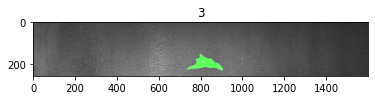

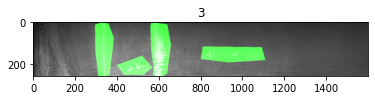

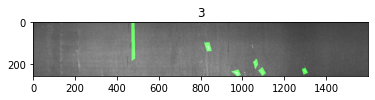

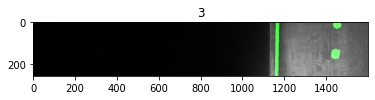

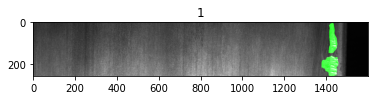

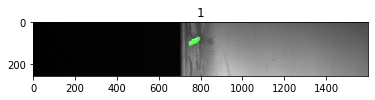

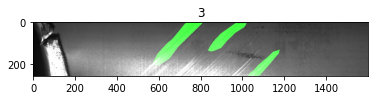

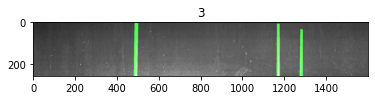

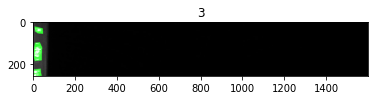

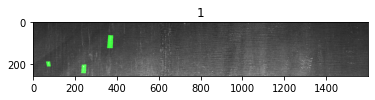

In [80]:
# Testando a mascara com a base de dados de teste
for i in range(10):
  img = io.imread(os.path.join(train_dir, test_df['ImageId'][i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mask = rle2mask(test_df['EncodedPixels'][i], img.shape[0], img.shape[1])
  img[mask == 1,1] = 255
  plt.figure()
  plt.title(test_df['ClassId'][i])
  plt.imshow(img)

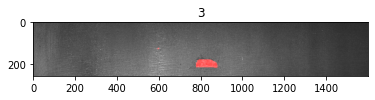

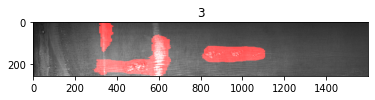

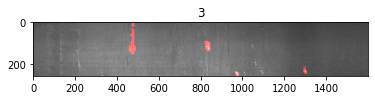

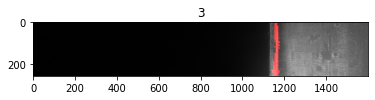

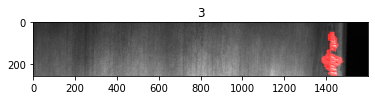

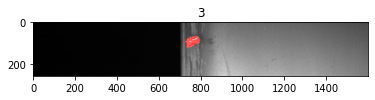

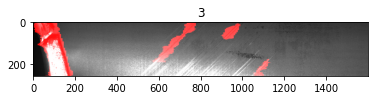

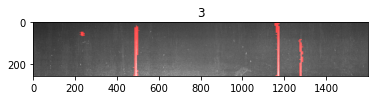

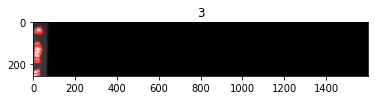

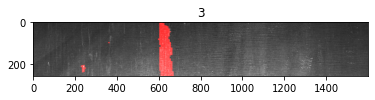

In [81]:
# Testando a mascara com a base de dados de validação
for i in range(10):
  img = io.imread(os.path.join(train_dir, df_pred['ImageId'][i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mask = rle2mask(df_pred['EncodedPixels'][i], img.shape[0], img.shape[1])
  img[mask == 1,0] = 255
  plt.figure()
  plt.title(df_pred['ClassId'][i])
  plt.imshow(img)